In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Define filepaths
path_coe = 'data/COEBiddingResultsPrices.csv'
path_deregistered = 'data/MotorVehiclesDeRegisteredUnderVehicleQuotaSystemMonthly.csv'
path_registered = 'data/NewRegistrationOfMotorVehiclesUnderVehicleQuotaSystemMonthly.csv'
path_cpi = 'data/outputFile.xlsx'
path_nom_household = 'data/NominalChangeinAverageMonthlyHouseholdEmploymentIncomePerHouseholdMemberExcludingEmployerCPFContributionsAmongResidentEmployedHouseholdsbyDecilesHouseholdEmploymentIncomeAnnual20002024.csv'
#path_real_household = 'data/RealChangeinMonthlyHouseholdEmploymentIncomePerHouseholdMemberExcludingEmployerCPFContributionsAmongResidentEmployedHouseholdsatSelectedPercentilesHouseholdEmploymentIncomeAnnual20002024.csv'
path_core_inflation = 'data/MAS Core Inflation.xlsx'

# Load datasets
coe = pd.read_csv(path_coe, thousands=',') #thousands separator causing issues
deregistered = pd.read_csv(path_deregistered)
registered = pd.read_csv(path_registered)
cpi = pd.read_excel(path_cpi, sheet_name='T7', skiprows=10) #the only xlsx file
nom_household = pd.read_csv(path_nom_household)
inflation = pd.read_excel(path_core_inflation)

def basicprep_cpi(cpi):
    cpi_t = cpi.transpose()
    cpi_t.columns = cpi_t.iloc[0] #declare header
    cpi_t = cpi_t[1:] #remove extra header
    cpi_t.reset_index(inplace=True)
    cpi_t.rename_axis(None, axis=1, inplace=True) #index was called "Data Series"
    cpi_t.rename(columns={'index': 'month'}, inplace=True)
    cpi_mainmetric = cpi_t[['month','All Items']] #only interested in 'All Items'
    cpi_mainmetric_sorted = cpi_mainmetric[::-1] #reverse the order to have earliest month first

    # Cut off at earliest date of coe dataset
    index_of_earliestdate = cpi_mainmetric_sorted[cpi_mainmetric_sorted['month'] == '2010 Jan'].index[0]
    cpi_mainmetric_sorted_earliestdate = cpi_mainmetric_sorted.loc[index_of_earliestdate:]

    # Convert date format to YYYY-MM
    text_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    numerical_months = ['01','02','03','04','05','06','07','08','09','10','11','12']
    cpi_mainmetric_sorted_earliestdate.loc[:,'month'] = cpi_mainmetric_sorted_earliestdate.loc[:,'month'].apply(convert_date_format, args=(text_months, numerical_months))

    # Re-base to 2010 months
    #cpi_mainmetric_sorted_earliestdate_rebased = rebase_index_old(cpi_mainmetric_sorted_earliestdate, 2010, 2010, 2026, 'month', 'All Items', numerical_months)
    cpi_mainmetric_sorted_earliestdate['cpi_reindexed'] = cpi_mainmetric_sorted_earliestdate.apply(rebase_index, axis=1, args=(cpi_mainmetric_sorted_earliestdate.copy(), 2010, 'month', 'All Items'))
    return cpi_mainmetric_sorted_earliestdate

def basicprep_coe(coe):
    # Cut off at last date of Nov 2025
    index_of_2025Nov = coe[coe['month'] == '2025-11'].index[-1] #get the last occurrence
    coe_nov25 = coe.loc[:index_of_2025Nov]

    # Average bids 1 and 2
    coe_nov25_bidavg = coe_nov25.groupby(['month','vehicle_class']).mean().reset_index().drop(columns=['bidding_no'])

    # Flatten multiindex columns
    coe_nov25_bidavg.columns = coe_nov25_bidavg.columns.to_flat_index()
    #coe_nov25_bidavg.to_csv('temp.csv')

    # Index COE premiums to 2010 values
    coe_nov25_bidavg['coe_indexed'] = coe_nov25_bidavg.apply(rebase_index, axis=1, args=(coe_nov25_bidavg.copy(), 2010, 'month', 'premium', 'vehicle_class'))
    return coe_nov25_bidavg

# Function to convert date format to YYYY-MM in digits
def convert_date_format(x, original_months, converted_months):
    ref_dict = dict(zip(original_months, converted_months))
    this_date = x[5:] #start the search from the 5th character to skip the year and space
    return f'{x[:4]}-{ref_dict[this_date]}'

# (OLD) Function to rebase values to their corresponding month in a base year
def rebase_index_old(df, year_base, year_start, year_end_excl, label_time, label_value, list_months): #only for unique year-months
    list_years = [i for i in range(year_start,year_end_excl)]
    for month in list_months:
        base_year_month_value = float(df.loc[df[label_time] == f'{year_base}-{month}',label_value].iloc[0])
        for year in list_years:
            try:
                current_value = float(df.loc[df[label_time] == f'{year}-{month}',label_value].iloc[0])
                rebased_value = round((current_value / base_year_month_value) * 100,3)
                df.loc[df[label_time] == f'{year}-{month}', f'{label_value}_rebased'] = rebased_value
            except: #dates may not be found
                print(f'Error for {year} {month}: {df.loc[df[str(label_time)] == f'{year}-{month}']}')
                pass
    return df

# Returns the rebased value for a single row, using specifc date format YYYY-MM
def rebase_index(row, staticdf, year_base, label_time, label_value, label_category=True): #optional label_category just for coe
    value = row[label_value]
    month = row[label_time][5:]
    #print(f'{month}: {value}')
    if label_category==True: #no category label, no need secondary check
        #print('no secondary condition')
        value_base = float(staticdf.loc[staticdf[label_time] == f'{year_base}-{month}', label_value].iloc[0])
        #print(value_base)
        return round(value/value_base*100,3)
    else:
        value_base = float(staticdf.loc[(staticdf[label_time] == f'{year_base}-{month}') & (staticdf[label_category] == row[label_category]), label_value].iloc[0])
        #print(f'base value: {value_base}')
        return round(value/value_base*100,3)
    
def get_common_dates(df_list, date_col_name):
    df1 = df_list[0]
    common_dates = [date for date in df1[date_col_name].to_list()]
    for each_other_df in df_list[1:]:
        for date in common_dates:
            if date not in each_other_df[date_col_name].to_list():
                common_dates.remove(date)
    return common_dates

#def trim_to_common_dates_only():
    

In [5]:
# CPI dataset
df_cpi = basicprep_cpi(cpi)

# COE dataset
df_coe = basicprep_coe(coe)
df_coe_a = df_coe.loc[df_coe['vehicle_class'] == 'Category A']
df_coe_b = df_coe.loc[df_coe['vehicle_class'] == 'Category B']
df_coe_d = df_coe.loc[df_coe['vehicle_class'] == 'Category D']

# Trim datasets to only the common dates so that we can plot
df_list = [df_cpi, df_coe_a, df_coe_b, df_coe_d]
common_dates = get_common_dates(df_list, 'month')
df_cpi_trim = df_cpi[df_cpi['month'].isin(common_dates)]
df_coe_a_trim = df_coe_a[df_coe_a['month'].isin(common_dates)]
df_coe_b_trim = df_coe_b[df_coe_b['month'].isin(common_dates)]
df_coe_d_trim = df_coe_d[df_coe_d['month'].isin(common_dates)]

C:\Users\user\AppData\Local\Temp\ipykernel_12576\3740348790.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_mainmetric_sorted_earliestdate['cpi_reindexed'] = cpi_mainmetric_sorted_earliestdate.apply(rebase_index, axis=1, args=(cpi_mainmetric_sorted_earliestdate.copy(), 2010, 'month', 'All Items'))


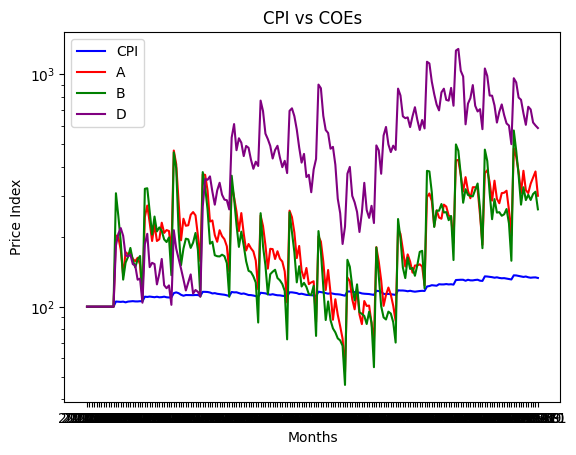

In [8]:
plt.plot(df_cpi_trim['month'], df_cpi_trim['cpi_reindexed'], label='CPI', color='blue')
plt.plot(df_cpi_trim['month'], df_coe_a_trim['coe_indexed'], label='A', color='red')
plt.plot(df_cpi_trim['month'], df_coe_b_trim['coe_indexed'], label='B', color='green')
plt.plot(df_cpi_trim['month'], df_coe_d_trim['coe_indexed'], label='D', color='purple')

plt.xlabel('Months')
plt.ylabel('Price Index')
plt.title('CPI vs COEs')
plt.yscale('log') # Set the y-axis to a logarithmic scale
plt.legend()
plt.show()


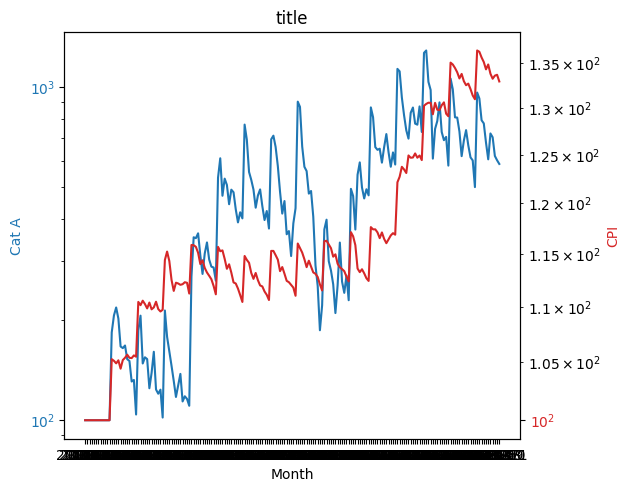

In [114]:
def plot_twin_axis(x, y1, y2, y1_label, y2_label, title):
    fig, ax1 = plt.subplots()

    colour_ax1 = 'tab:blue'
    ax1.set_xlabel('Month')
    ax1.set_ylabel(y1_label, color=colour_ax1)
    ax1.plot(x, y1, color=colour_ax1)
    ax1.tick_params(axis='y', labelcolor=colour_ax1)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    colour_ax2 = 'tab:red'
    ax2.set_ylabel(y2_label, color=colour_ax2)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=colour_ax2)
    ax2.tick_params(axis='y', labelcolor=colour_ax2)

    plt.xticks(rotation=90)
    ax1.autoscale(enable=True, axis='x')
    ax2.autoscale(enable=True, axis='x')
    ax1.set_yscale('log')
    ax2.set_yscale('log')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()

plot_twin_axis(df_cpi_trim['month'], df_coe_d_trim['coe_indexed'], df_cpi_trim['cpi_reindexed'], 'Cat A', 'CPI', 'title')

In [110]:
df_coe_d_trim

,month,vehicle_class,quota,bids_success,bids_received,premium,coe_indexed
3,2010-01,Category D,375.5,371.5,530.0,870.5,100.000
8,2010-02,Category D,367.0,352.0,498.5,926.5,100.000
13,2010-03,Category D,378.0,375.5,481.0,1179.5,100.000
18,2010-04,Category D,338.5,322.5,396.0,1237.0,100.000
23,2010-05,Category D,352.0,338.5,441.5,1282.0,100.000
...,...,...,...,...,...,...,...
918,2025-07,Category D,536.5,533.5,625.5,9450.0,724.138
923,2025-08,Category D,536.5,530.5,643.5,8999.0,705.251
928,2025-09,Category D,539.5,539.5,625.0,9155.0,619.838
933,2025-10,Category D,533.0,528.0,614.0,9599.5,601.661


In [ ]:
coe_nov25_filtered_bidavg[['month','vehicle_class','premium']]#.plot()

,month,vehicle_class,premium
0,2010-01,Category A,19501.5
1,2010-01,Category B,20795.0
2,2010-01,Category D,870.5
3,2010-02,Category A,20164.5
4,2010-02,Category B,23534.5
...,...,...,...
559,2025-10,Category B,136444.5
560,2025-10,Category D,9599.5
561,2025-11,Category A,109501.0
562,2025-11,Category B,122445.5


C:\Users\user\AppData\Local\Temp\ipykernel_6908\474436774.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_mainmetric_sorted_earliestdate['cpi_reindexed'] = cpi_mainmetric_sorted_earliestdate.apply(rebase_index, axis=1, args=(cpi_mainmetric_sorted_earliestdate.copy(), 2010, 'month', 'All Items'))


,month,All Items,cpi_reindexed
190,2010-01,73.64,100.000
189,2010-02,73.771,100.000
188,2010-03,74,100.000
187,2010-04,74.596,100.000
186,2010-05,75.025,100.000
...,...,...,...
4,2025-07,100.704,133.806
3,2025-08,100.742,133.243
2,2025-09,101.099,133.591
1,2025-10,101.589,133.686
